In [3]:
%cd ..

/pub/hofmann-scratch/glanzillo/mammoth


In [4]:

import importlib
import math
import os
import socket
import sys
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
mammoth_path = os.path.abspath(os.path.join('.'))
if mammoth_path not in sys.path:
    print(mammoth_path)
    sys.path.append(mammoth_path)
    sys.path.append(mammoth_path + '/datasets')
    sys.path.append(mammoth_path + '/backbone')
    sys.path.append(mammoth_path + '/models')
    sys.path.append(mammoth_path + '/utils')


import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch

from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageNet, ImageFolder
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, resnet18
import torchvision.transforms as transforms


/pub/hofmann-scratch/glanzillo/mammoth


/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
%ls

LICENSE    gem_license   models/           seq_cifar10.gif  wandb/
README.md  logo.png      perm_mnist.gif    seq_mnist.gif
backbone/  logs/         requirements.txt  seq_tinyimg.gif
data/      logs.txt      rot_mnist.gif     tests/
datasets/  mnist360.gif  scripts/          utils/


In [6]:
logs_path = './logs/results/imagenet/resnet50/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [7]:
res_df = pd.DataFrame(results)
res_df

,distributed,lr,checkpoints,pretrained,optim_wd,optim_mom,optim_nesterov,n_epochs,batch_size,validate_subset,...,wandb_name,buffer_size,minibatch_size,alpha,noisy_buffer,final_val_acc_D,buffer_train_time,final_train_acc_S,final_train_leftout_acc_S,final_val_acc_S
0,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,None,1200,None,0.0,False,76.034,1303.681807,3.333333,0.767263,1.168
1,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,None,1200,None,0.0,False,76.034,1324.478126,3.166667,1.023018,1.234
2,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,None,1200,None,0.0,False,76.034,1328.220785,3.916667,0.767263,1.400
3,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,None,1200,None,0.0,False,76.034,1316.642873,3.500000,1.023018,1.232
4,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,None,1200,None,0.0,False,76.034,1230.671725,3.166667,1.534527,1.266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,None,240000,None,1.0,False,76.034,66606.508847,79.166667,54.859335,62.268
110,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,None,240000,None,1.0,False,76.034,66633.788555,79.211667,54.347826,61.476
111,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,None,240000,None,1.0,False,76.034,66741.507632,79.092083,57.161125,61.820
112,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,None,240000,None,1.0,False,76.034,66951.980386,77.760833,56.393862,59.968


In [8]:
buffer_sizes = [1200, 12000, 60000, 120000, 240000, 360000, 480000] 

In [85]:
teacher_val_accuracy = res_df['final_val_acc_D'][0]
teacher_train_accuracy = 77.50
teacher_val_accuracy

76.034

In [10]:
res_df['buffer_size_p'] = 100*res_df['buffer_size']/(1200000)
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
res_df['final_val_acc_S_p'] = 100*res_df['final_val_acc_S']/(teacher_val_accuracy)
res_df['final_train_acc_S_p'] = 100*res_df['final_train_acc_S']/(teacher_val_accuracy)
working_df = res_df.loc[res_df['buffer_size'].isin(buffer_sizes)]
working_df

,distributed,lr,checkpoints,pretrained,optim_wd,optim_mom,optim_nesterov,n_epochs,batch_size,validate_subset,...,noisy_buffer,final_val_acc_D,buffer_train_time,final_train_acc_S,final_train_leftout_acc_S,final_val_acc_S,buffer_size_p,generalization_gap,final_val_acc_S_p,final_train_acc_S_p
0,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,False,76.034,1303.681807,3.333333,0.767263,1.168,0.1,-2.165333,1.536155,4.384004
1,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,False,76.034,1324.478126,3.166667,1.023018,1.234,0.1,-1.932667,1.622958,4.164803
2,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,False,76.034,1328.220785,3.916667,0.767263,1.400,0.1,-2.516667,1.841282,5.151204
3,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,False,76.034,1316.642873,3.500000,1.023018,1.232,0.1,-2.268000,1.620328,4.603204
4,no,0.1,True,False,0.0001,0.9,0,90,64,1000,...,False,76.034,1230.671725,3.166667,1.534527,1.266,0.1,-1.900667,1.665045,4.164803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,False,76.034,66606.508847,79.166667,54.859335,62.268,20.0,-16.898667,81.894942,104.120087
110,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,False,76.034,66633.788555,79.211667,54.347826,61.476,20.0,-17.735667,80.853302,104.179271
111,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,False,76.034,66741.507632,79.092083,57.161125,61.820,20.0,-17.272083,81.305732,104.021995
112,no,0.1,True,False,0.0001,0.9,0,90,64,2000,...,False,76.034,66951.980386,77.760833,56.393862,59.968,20.0,-17.792833,78.869979,102.271133


In [11]:
working_df['buffer_size_p'].unique()

array([ 0.1,  1. ,  5. , 10. , 20. ])

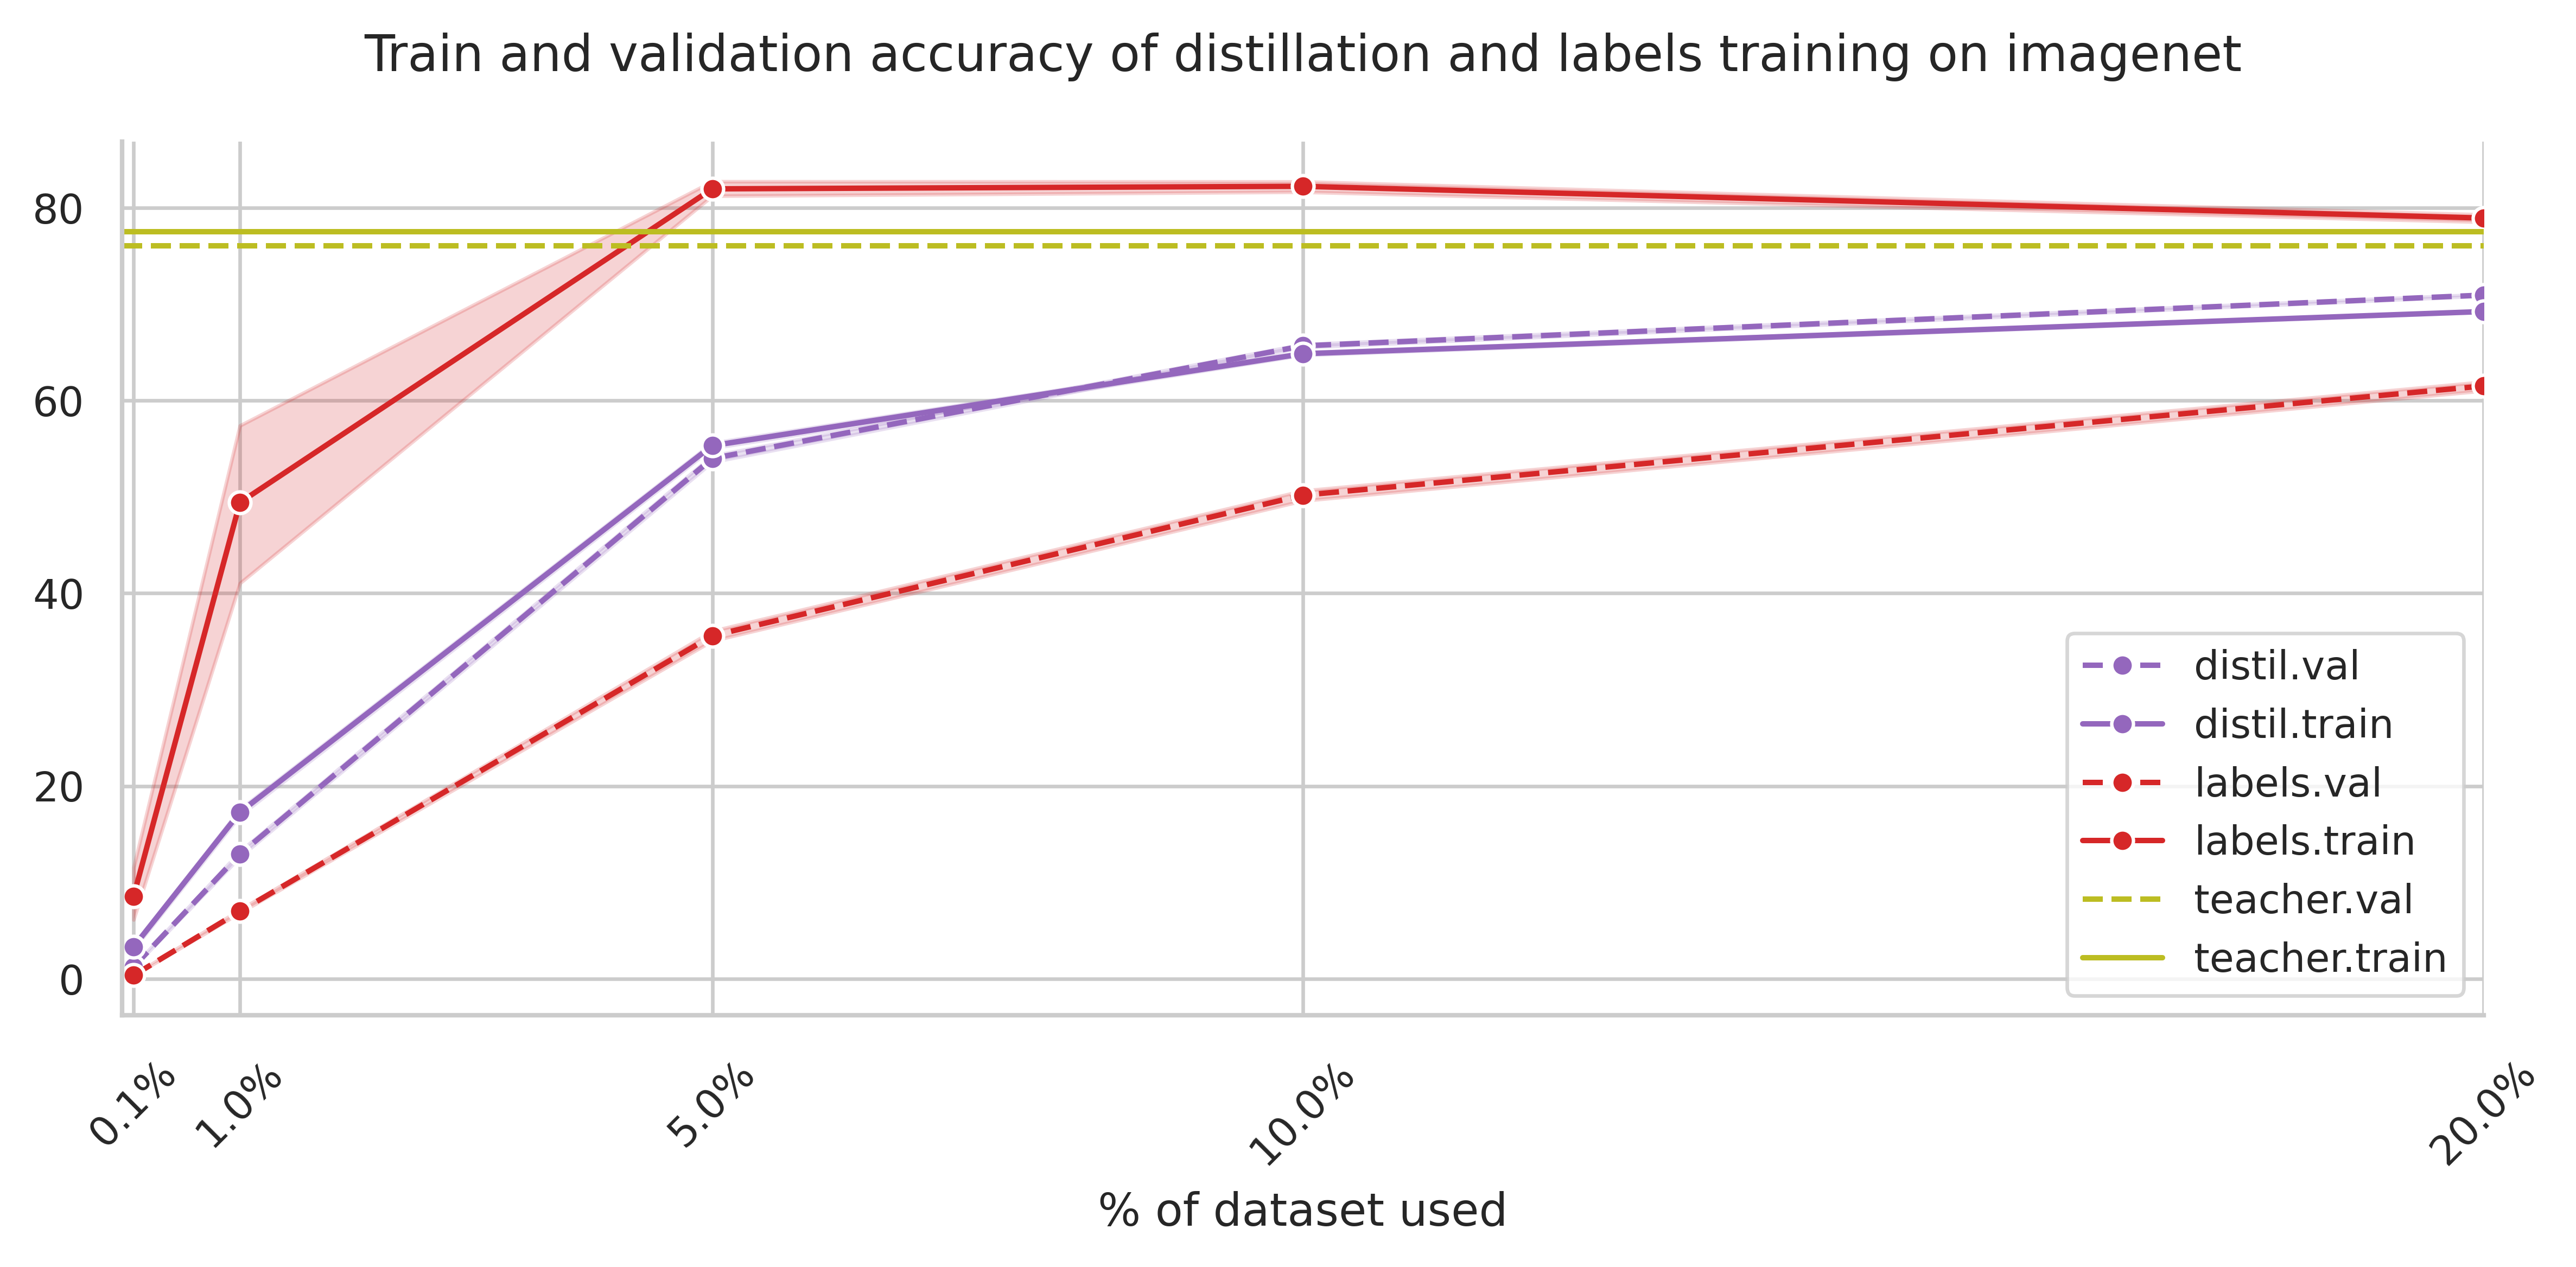

In [89]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8,4), sharey=True, dpi=600)
    colors = ['tab:purple','tab:red','tab:olive']
    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", 
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", 
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", 
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", 
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    ax.axhline(76.034, ls='--', color=colors[2], label="a")
    ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    # ax.set_xscale('log')
    # #ax.set_yscale('symlog',linthresh=10e-0)
    ax.set_xlim([0.001,0.4])
    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}%' for l in working_df['buffer_size_p'].unique()], fontsize=9)
    ax.tick_params(axis='x',  rotation=45)

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Train and validation accuracy of distillation and labels training on imagenet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'% of dataset used', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['distil.val','distil.train',
                  'labels.val','labels.train',
                  'teacher.val','teacher.train'], title="", ncol=1)

    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)
    sns.despine()
    plt.tight_layout()


## Covariance exploration

In [21]:
from utils.loggers import *
from utils.conf import set_random_seed, get_device
from utils.status import ProgressBar

In [14]:
DEVICE=[1]
device = get_device(DEVICE)

In [15]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "/chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          if filename=='checkpoint_90.pth.tar' and not distributed: # modify Sidak's checkpoint
                new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
                checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [16]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

In [17]:
from torch.utils.data import ConcatDataset

In [18]:
all_data = ConcatDataset([train_dataset, val_dataset])
all_data_loader = DataLoader(
        all_data, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

In [19]:
# initialising the model
weights = None
model = resnet50(weights=weights)

chkpt_name = f"checkpoint_90.pth.tar" #sidak's checkpoint
checkpoint = load_checkpoint(best=False, filename=chkpt_name, distributed=False) #TODO: switch best off
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
best_acc1 = checkpoint['best_acc1']

Loading existing checkpoint ./logs//chkpts/imagenet/resnet50/checkpoint_90.pth.tar


#### First, we register train accuracy

In [84]:
train_loader = DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)
#TODO: add estimate of the average teacher logits magnitude
progress_bar = ProgressBar(verbose=True)
correct, total = 0.0, 0.0
average_magnitude = 0
for i,data in enumerate(train_loader):
        #if i==3: break
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            average_magnitude += (outputs.max(dim=1)[0]-outputs.min(dim=1)[0]).sum(dim=0)
            _, pred = torch.max(outputs.data, 1)
            correct += torch.sum(pred == labels).item()
            total += labels.shape[0]
        progress_bar.prog(i, len(train_loader), -1, 'D', (correct / total) * 100)     
acc=(correct / total) * 100
average_magnitude /= total

[ 08-01 | 19:47 ] Task D | epoch -1: |██████████████████████████████████████████████████| 1.79 ep/h | loss: 77.50777221 |

#### Now we collect all the labels and all the outputs

In [53]:
# running estimate of the outer products and mean
Y2 = 0; Ymu = 0; t2 = 0; tmu = 0; total=0
C = 1000
progress_bar = ProgressBar(verbose=True)

for i, data in enumerate(all_data_loader):
    #if i==10: break # for testing
    with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=C).view(-1,C,1).to(torch.float64)
            outputs = model(inputs)
            outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
            total += labels.shape[0]
            Y2 += torch.matmul(labels,labels.permute(0,2,1)).sum(dim=0)
            Ymu += labels.sum(dim=0)
            t2 += torch.matmul(outputs,outputs.permute(0,2,1)).to(torch.float64).sum(dim=0)
            tmu += outputs.sum(dim=0)
    progress_bar.prog(i, len(all_data_loader), -1, 'D', i/(len(all_data_loader)))  
    
# summing over the batch dimension 
Ymu = Ymu/total
tmu = tmu/total
# subtracting the mean and averaging
SigmaY = (Y2 - torch.matmul(Ymu.view(C,1),Ymu.view(1,C)))/((total-1))
SigmaT = (t2 - torch.matmul(tmu.view(C,1),tmu.view(1,C)))/((total-1))

/tmp/ipykernel_2101918/2421696559.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
[ 08-01 | 17:58 ] Task D | epoch -1: |██████████████████████████████████████████████████| 1.62 ep/h | loss: 0.99995192 |

In [50]:
t2.shape

torch.Size([1000, 1000])

In [ ]:
SigmaY = SigmaY.detach().cpu().numpy()
SigmaT = SigmaT.detach().cpu().numpy()

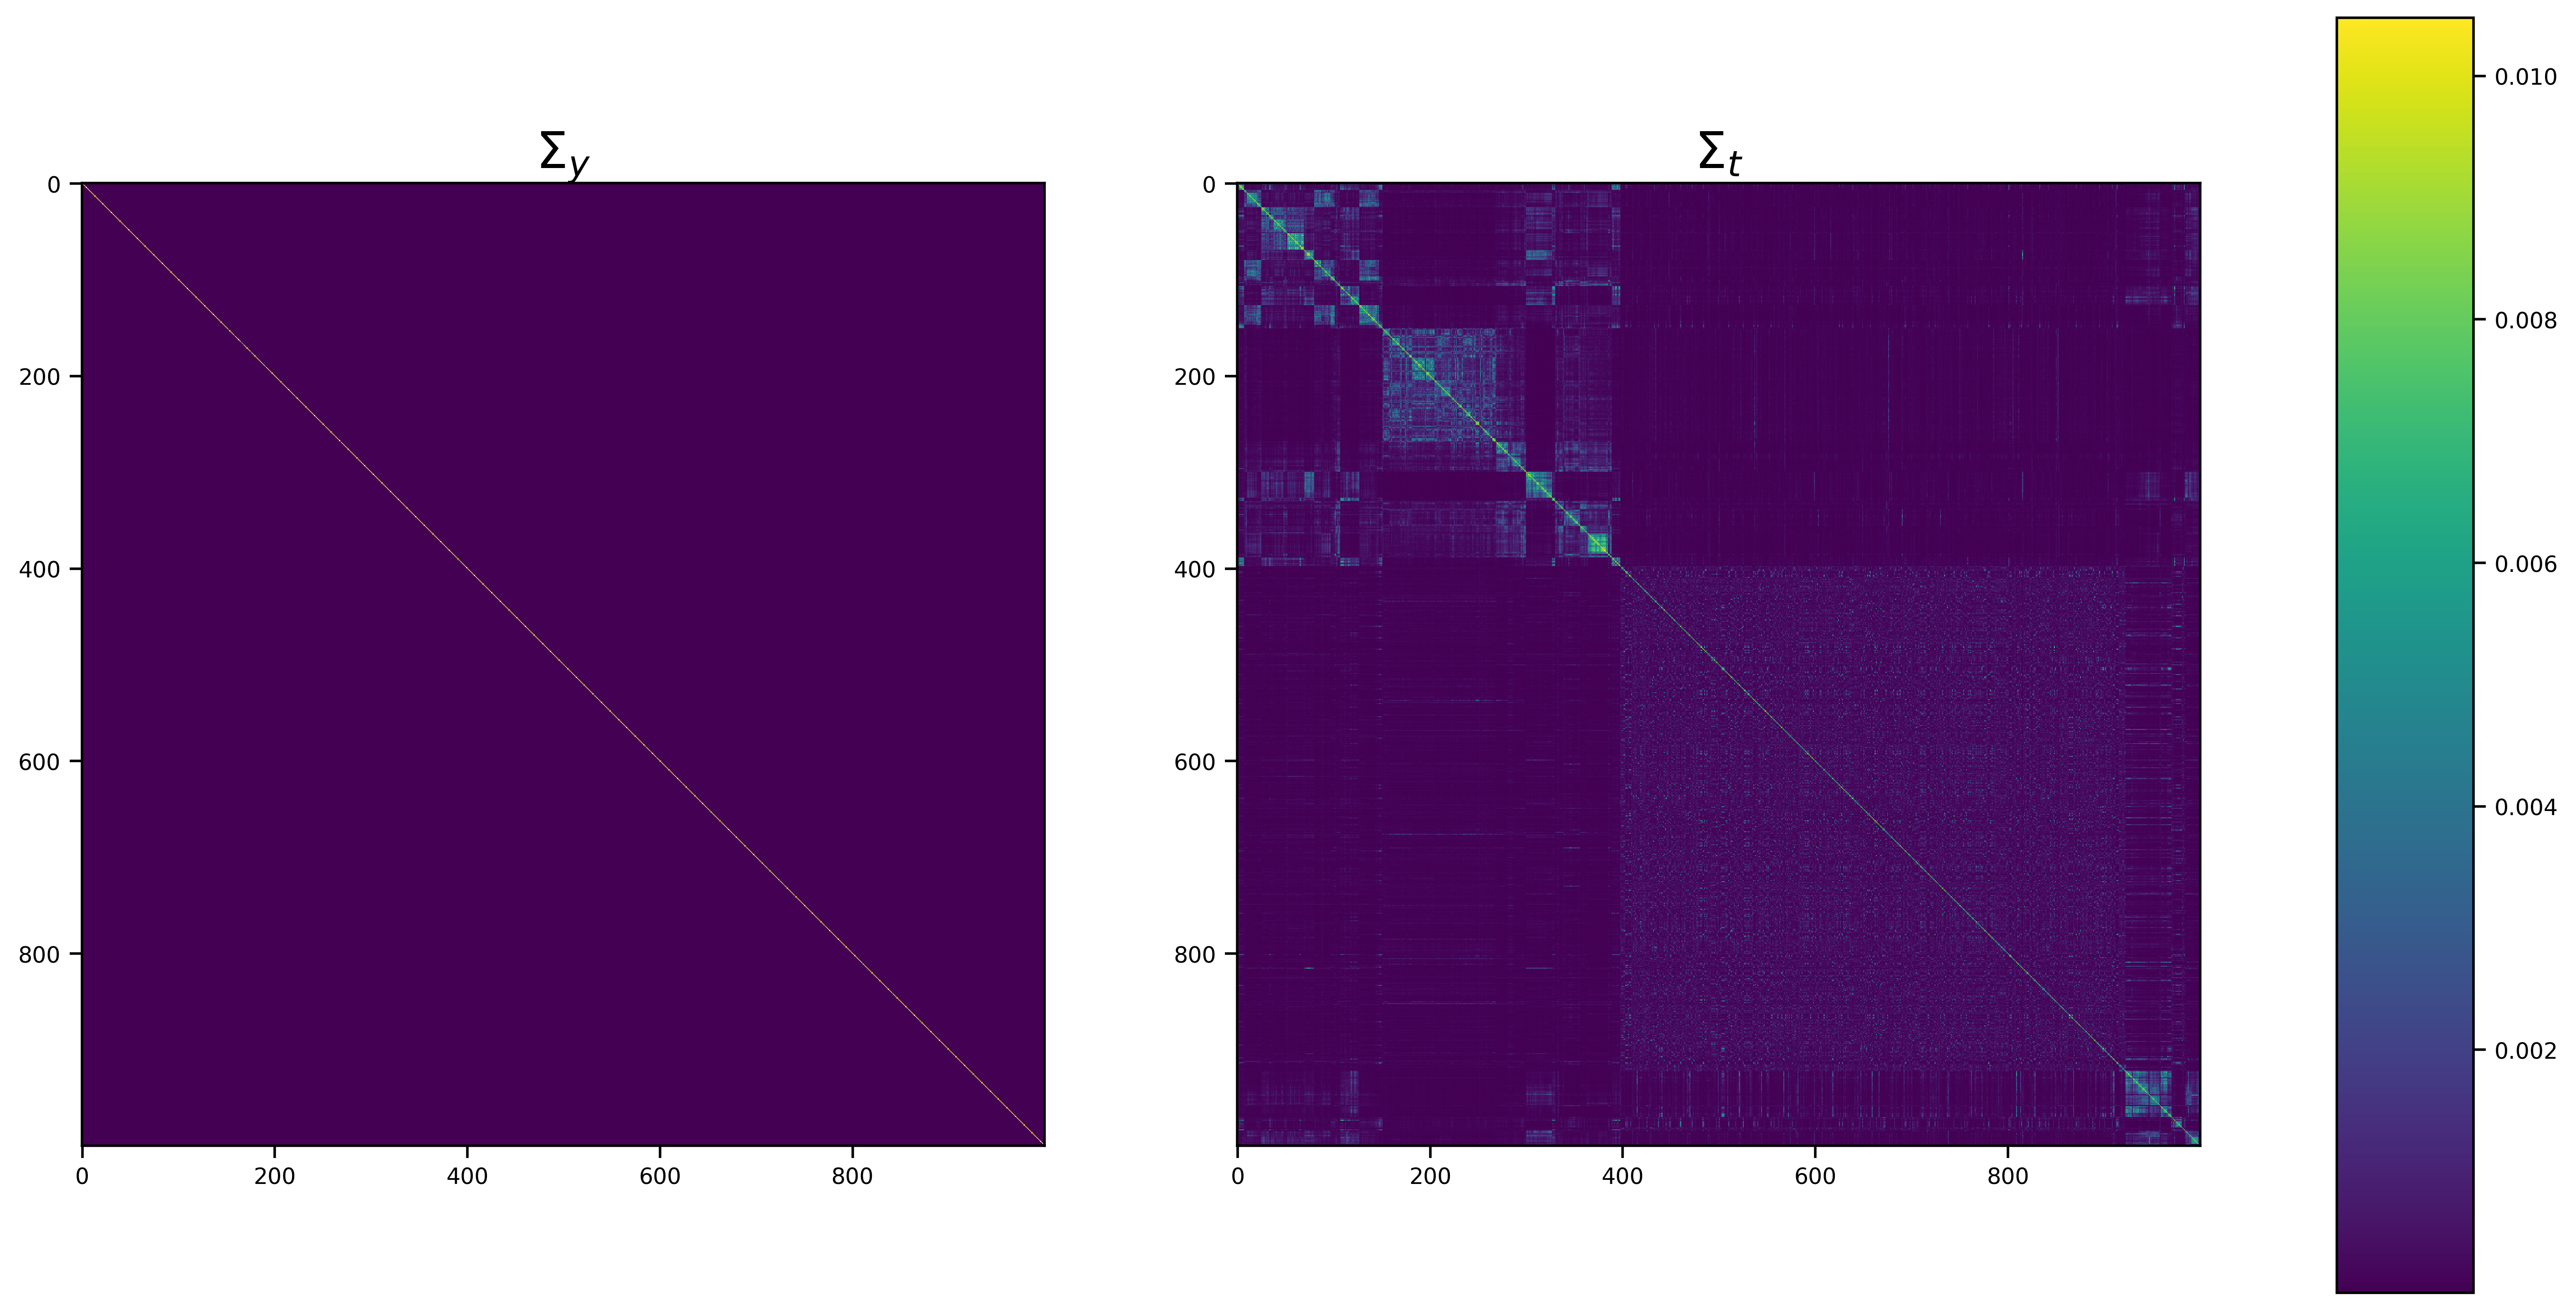

In [92]:
#M = SigmaT.detach().cpu().numpy()
#assert (M == M.T).sum() == 1000**2
fig, ax = plt.subplots(1,2, figsize=(15,10), dpi=400)

mat = ax[0].matshow(SigmaY)
ax[0].set_title(r'$\Sigma_y$',fontsize=20)
ax[0].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[0].tick_params(axis='y', colors='black', bottom=True, top=False)

mat = ax[1].matshow(SigmaT)
ax[1].set_title(r'$\Sigma_t$',fontsize=20)
ax[1].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[1].tick_params(axis='y', colors='black', bottom=True, top=False)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)
#fig.colorbar(mat, ax=ax[1], location='right', anchor=(0, 0.5), shrink=0.7)

In [57]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
np.save(path + "SigmaY.npy", SigmaY)
np.save(path + "SigmaT.npy", SigmaT)

Now we perform an eigenvalue analysis

Text(0.5, 1.0, 'Distribution')

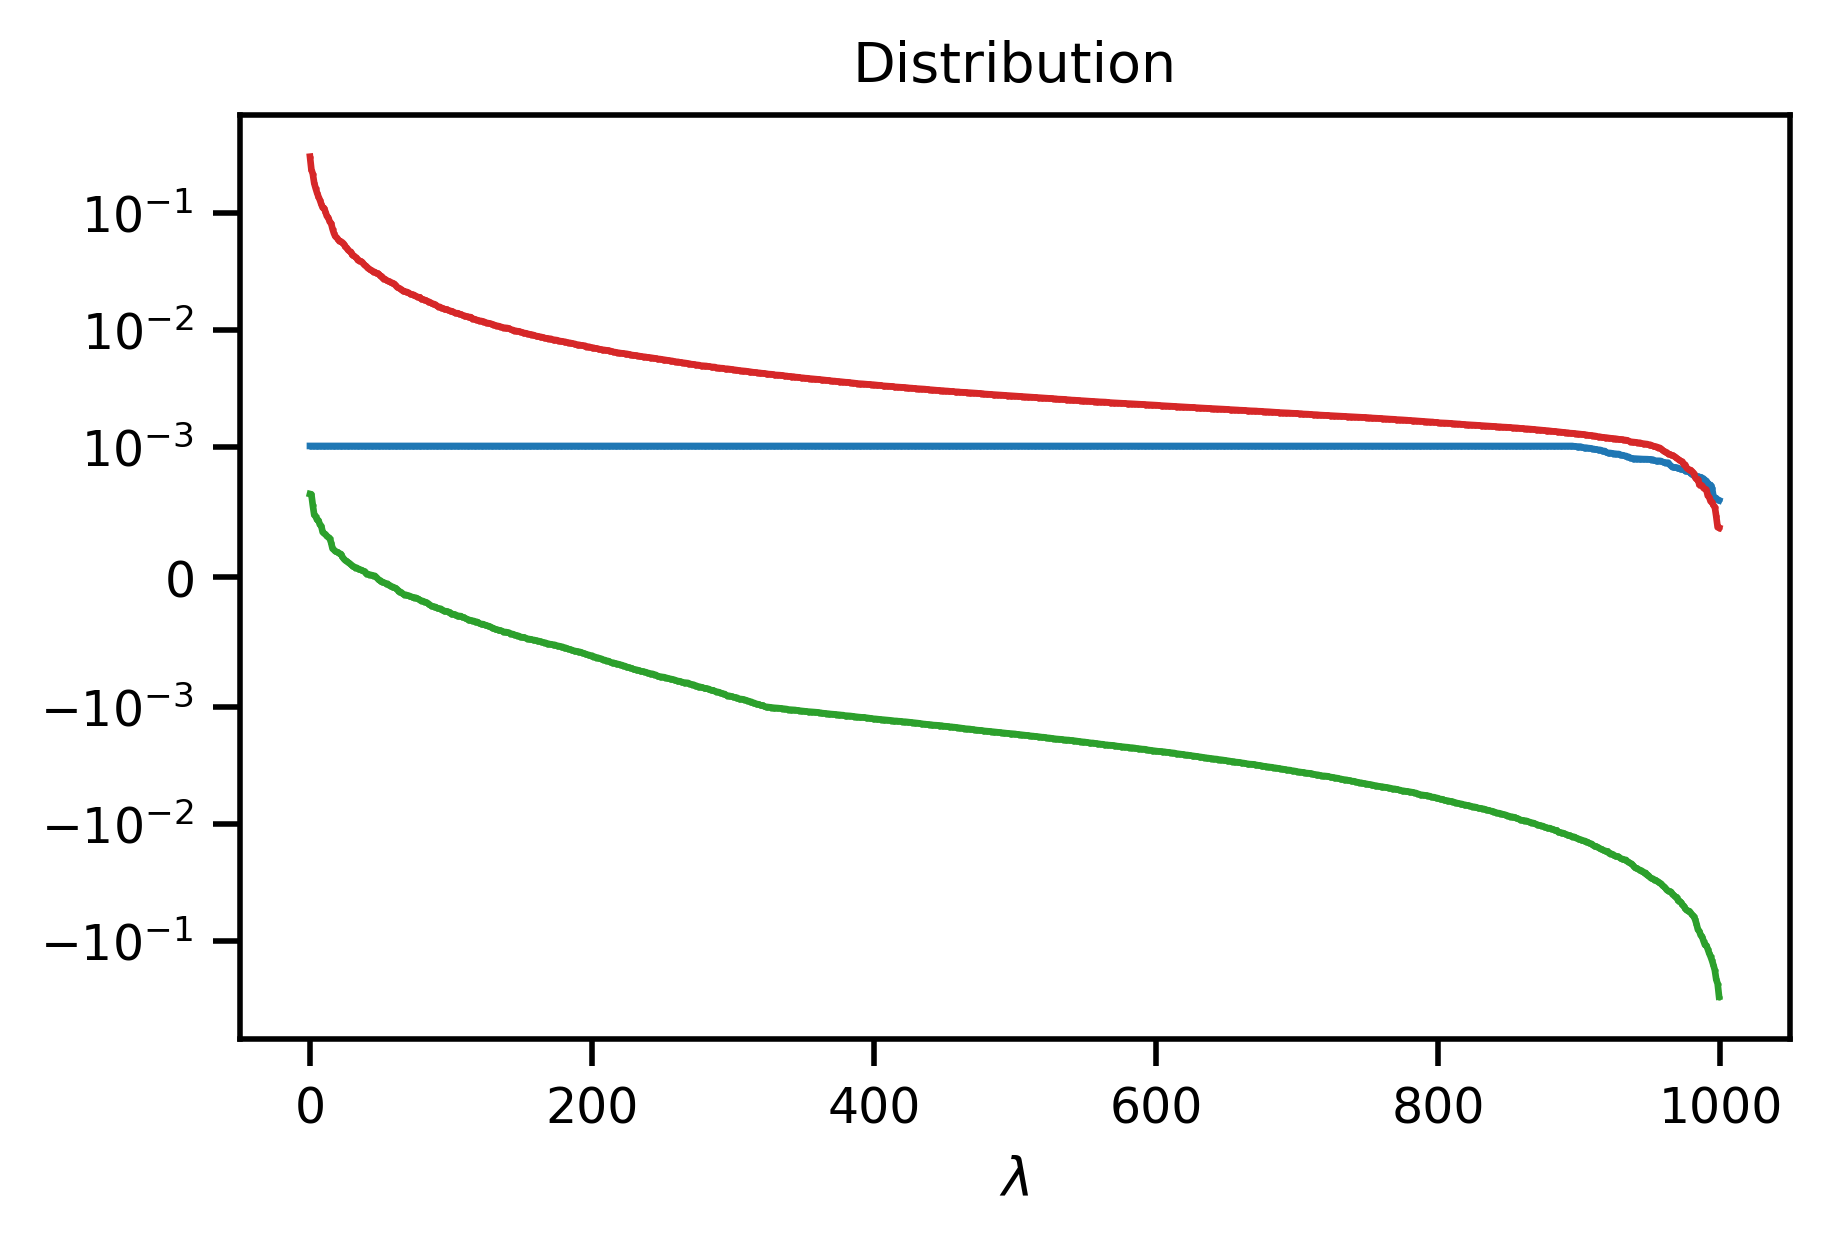

In [118]:
fig, ax = plt.subplots(figsize=(5,3), dpi=400)

L, V = np.linalg.eigh(SigmaY)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:red')
x = list(range(L.shape[0]))
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:blue', ms=0.5)
L, V = np.linalg.eigh(SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:red', ms=0.5)
L, V = np.linalg.eigh(SigmaY-SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:green', ms=0.5)
#ax.set_xscale('symlog', linthresh=0.001)
ax.set_yscale('symlog', linthresh=10e-4)
#ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Distribution', fontsize=10)
